In [22]:
# Probabilistic Matrix Factorization implementation using PyTorch

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.model_selection import KFold

In [5]:
# Load the data
data = pd.read_csv('ratings_small.csv')
data = data.drop('timestamp', axis=1)
data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [ ]:
# Split the data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# Create a class for the dataset
class MoviesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user_id = self.data.iloc[idx, 0]
        movie_id = self.data.iloc[idx, 1]
        rating = self.data.iloc[idx, 2].astype(np.float32)
        return user_id, movie_id, rating

# Create the dataset
train_dataset = MoviesDataset(train)
test_dataset = MoviesDataset(test)

In [8]:
# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [9]:
# Create the model
class PMF(nn.Module):
    def __init__(self, total_users, total_movies, latent_factors):
        super(PMF, self).__init__()
        self.total_users = total_users
        self.total_movies = total_movies
        self.latent_factors = latent_factors

        self.user_embeddings = nn.Embedding(self.total_users, self.latent_factors)
        self.movie_embeddings = nn.Embedding(self.total_movies, self.latent_factors)

    def forward(self, user_id, movie_id):
        user_embedding = self.user_embeddings(user_id)
        movie_embedding = self.movie_embeddings(movie_id)
        output = torch.mul(user_embedding, movie_embedding)
        output = torch.sum(output, dim=1)

        return output

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# total users
total_users = max(data['userId']) + 1

# total movies
total_movies = max(data['movieId']) + 1

In [12]:
def model_setup(total_users, total_movies, latent_factors):
    model = PMF(total_users, total_movies, latent_factors)
    criterion = nn.MSELoss()
    
    # Optimizer with l2 regularization
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    model.to(device)

    return model, criterion, optimizer

In [13]:
# Train the model
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        model.train()
        # start time for epoch
        start = time.time()
        for user_id, movie_id, rating in train_loader:
            optimizer.zero_grad()
            user_id = user_id.to(device)
            movie_id = movie_id.to(device)
            rating = rating.to(device)
            
            output = model(user_id, movie_id)

            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * rating.size(0)
        train_loss = train_loss / len(train_loader.sampler)
        train_losses.append(train_loss)

        model.eval()
        for user_id, movie_id, rating in test_loader:
            user_id = user_id.to(device)
            movie_id = movie_id.to(device)
            rating = rating.to(device)
            output = model(user_id, movie_id)
            loss = criterion(output, rating)
            test_loss += loss.item() * rating.size(0)
        test_loss = test_loss / len(test_loader.sampler)
        test_losses.append(test_loss)

    return train_losses, test_losses  

In [14]:
# RMSE
def rmse(actual, predictions):
    return sqrt(mean_squared_error(actual, predictions))

In [15]:
# MAE
def mae(actual, predictions):
    return mean_absolute_error(actual, predictions)

In [16]:
def evaluate_pmf(model, test_loader):
    model.eval()
    predictions = []
    actual = []
    for user_id, movie_id, rating in test_loader:
        user_id = user_id.to(device)
        movie_id = movie_id.to(device)
        rating = rating.to(device)
        output = model(user_id, movie_id)
        predictions.extend(output.cpu().detach().numpy())
        actual.extend(rating.cpu().detach().numpy())
    
    rmse_pred = rmse(actual, predictions)
    mae_pred = mae(actual, predictions)
    return rmse_pred, mae_pred

100%|██████████| 10/10 [19:10<00:00, 115.07s/it]


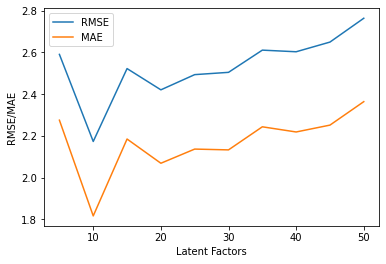

In [17]:
# calculate rmse and mae for different latent factors and plot the results
latent_factors = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
rmse_results = []
mae_results = []
for latent_factor in tqdm(latent_factors):
    model, criterion, optimizer = model_setup(total_users, total_movies, latent_factor)
    train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10)
    rmse_pred, mae_pred = evaluate_pmf(model, test_loader)
    rmse_results.append(rmse_pred)
    mae_results.append(mae_pred)

# plot the results
plt.plot(latent_factors, rmse_results, label='RMSE')
plt.plot(latent_factors, mae_results, label='MAE')
plt.xlabel('Latent Factors')
plt.ylabel('RMSE/MAE')
plt.legend()
plt.show()

5it [14:48, 177.67s/it]



RMSE:  [1.7534366650223294, 1.798481231608492, 1.766670187760689, 1.7259434069066704, 1.7611390236301558]
Average RMSE:  1.7611341029856675
MAE:  [1.4055008, 1.4492147, 1.4195558, 1.3783207, 1.4102627]
Average MAE:  1.4125708


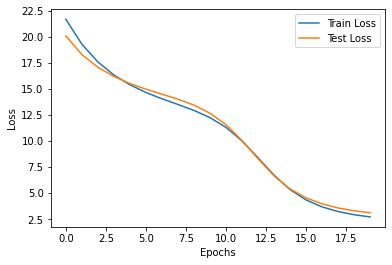

In [26]:
# train model with 10 latent factors for 20 epochs with 5 fold crossvalidation
data_splits = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_results = []
mae_results = []

for train_index, test_index in tqdm(data_splits.split(data)):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    train_dataset = MoviesDataset(train_data)
    test_dataset = MoviesDataset(test_data)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
    model, criterion, optimizer = model_setup(total_users, total_movies, 10)
    train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20)
    rmse_pred, mae_pred = evaluate_pmf(model, test_loader)
    rmse_results.append(rmse_pred)
    mae_results.append(mae_pred)

print('\n\nRMSE: ', rmse_results)
print('Average RMSE: ', np.mean(rmse_results))

print('MAE: ', mae_results)
print('Average MAE: ', np.mean(mae_results))

# plot the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()